In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py that executed in 36 hours

In [2]:
#monitor execution time
import time as tm
t_start = tm.time()

In [3]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('nothing')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  168


['permutations/sim_id=5!total_ring_mass=3.330000000000004e-13!shear_viscosity=1.043551627855571e-14!bulk_viscosity=1.043551627855571e-14!radial_width=5e-05!timesteps_per_output=98!',
 'permutations/sim_id=21!total_ring_mass=3.330000000000004e-13!shear_viscosity=1.0435516278555659e-12!bulk_viscosity=1.0435516278555659e-12!radial_width=5e-05!timesteps_per_output=140!',
 'permutations/sim_id=24!total_ring_mass=3.330000000000004e-13!shear_viscosity=3.299999999999998e-12!bulk_viscosity=3.299999999999998e-12!radial_width=2.5e-05!timesteps_per_output=143!',
 'permutations/sim_id=122!total_ring_mass=3.195132308221693e-11!shear_viscosity=3.3000000000000023e-14!bulk_viscosity=3.3000000000000023e-14!radial_width=0.0001!timesteps_per_output=1235!',
 'permutations/sim_id=56!total_ring_mass=3.2618691859696355e-12!shear_viscosity=3.3000000000000106e-15!bulk_viscosity=3.3000000000000106e-15!radial_width=2.5e-05!timesteps_per_output=1461!']

In [4]:
#prep plots
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [5]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('!total_ring_mass=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

,sim_id,path
0,0,permutations/sim_id=0!total_ring_mass=3.330000...
1,1,permutations/sim_id=1!total_ring_mass=3.330000...
2,2,permutations/sim_id=2!total_ring_mass=3.330000...
3,3,permutations/sim_id=3!total_ring_mass=3.330000...
4,4,permutations/sim_id=4!total_ring_mass=3.330000...


In [6]:
#nominal ringlet's properties
nominal_total_ring_mass = 1.0e-10
nominal_shear_viscosity = 3.3e-13
nominal_radial_width = 0.0001

In [7]:
#get outcome of every sim
plot_q = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    nan_timestep = monitor['nan_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['nan_timestep'] = nan_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #check if sim completed
    d['outcome'] = 'unsure'
    if ((streamline_crossing_timestep > 0) or (nan_timestep > 0)):
        d['outcome'] = 'crossed streamlines'
    if (streamline_crossing_timestep == None):
        if (nan_timestep == None):
            if (current_timestep == expected_timestep):
                d['outcome'] = 'simulation complete'
    
    #compute observed dynamical_timescale=time when q exceeds 0.6
    try:
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        jdx = (q > 0.6)
        d['dynamical_timescale'] = times[jdx][0]
        da0 = da[0]
        d['viscous_timescale'] = (da0**2)/(12.0*d['shear_viscosity'])
        if (plot_q):
            jdx = (q > 0)
            if (jdx.sum() > 0):
                xp = times[jdx]
                yp = q[jdx]
                sns.set(font_scale=1.0, font='DejaVu Sans')
                f, ax = plt.subplots(figsize=(10, 3))
                p = ax.plot(xp, yp, linestyle='-', label='q')
                yp = e_prime[jdx]
                p = ax.plot(xp, yp, linestyle='-', label="e'")
                xp = d['dynamical_timescale']
                kdx = (q > 0.6)
                yp = q[kdx][0]
                color = color_seq[3]
                p = ax.plot(xp, yp, marker='o', markersize=8, color=color, label=r'$\tau_{dyn}$')
                title = 'sim_id = ' + str(d['sim_id'])
                p = ax.set_title(title)
                p = ax.set_xlabel('times')
                p = ax.set_ylabel("q, e'")
                p = ax.set_ylim(0, 1)
                p = ax.legend()
    except:
        d['dynamical_timescale'] = np.nan
    
    #collect stats from completed sims
    if (d['outcome'] == 'simulation complete'):
        jdx = (times > 0.8*times.max())
        d['q'] = q[jdx].mean()
        d['delta_q'] = 0.5*(q[jdx].max() - q[jdx].min())
        d['dwt'] = dwt[jdx].mean()
        d['wt_prime'] = wt_prime[jdx].mean()
        d['e_prime'] = e_prime[jdx].mean()
        d['delta_q_over_q'] = d['delta_q']/d['q']
        
        #outcome=self-confining provided sim completes with q > 0.8
        if (d['q'] > 0.8):
            d['outcome'] = 'self-confining'
            e_prime_brackets = [0.0, 0.1, 0.6, 0.8]
            for e_prime_bracket in e_prime_brackets:
                if (d['e_prime'] > e_prime_bracket):
                    d['e_prime_bracket'] = e_prime_bracket
        else:
            #otherwise set dynamical_timescale=3*current_timestep
            d['dynamical_timescale'] = 3*current_timestep
            d['outcome'] = 'unconfined'
    
    data += [d]

df = pd.DataFrame(data)
print (df.outcome.value_counts())
print (df.e_prime_bracket.value_counts().sort_index(ascending=False))
df['nominal'] = False
small = 1.0e-15
df['r'] = np.abs(df.total_ring_mass - nominal_total_ring_mass + small) * \
    np.abs(df.shear_viscosity - nominal_shear_viscosity + small) * \
    np.abs(df.radial_width - nominal_radial_width + small)
idx = df.r.values.argmin()
df.loc[idx, 'nominal'] = True
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'timesteps_per_output', 'total_ring_mass', 'radial_width', 
    'shear_viscosity', 'bulk_viscosity', 'q', 'delta_q', 'delta_q_over_q', 'e_prime', 'dwt', 'wt_prime', 
    'outcome', 'e_prime_bracket', 'nominal', 'path']
df = df[cols]
df = df.sort_values('sim_id').reset_index(drop=True)
df.columns = df.columns.astype(str)
df_results = df
df_results.sample(5)

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:57: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:59: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:69: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)
/Users/joe/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


self-confining         111
crossed streamlines     56
unconfined               1
Name: outcome, dtype: int64
0.8    39
0.6    21
0.1    31
0.0    20
Name: e_prime_bracket, dtype: int64


,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,nan_timestep,dynamical_timescale,viscous_timescale,timesteps_per_output,total_ring_mass,radial_width,shear_viscosity,bulk_viscosity,q,delta_q,delta_q_over_q,e_prime,dwt,wt_prime,outcome,e_prime_bracket,nominal,path
152,152,1785000,1785000,1742088.0,1742877.0,89250.0,5.514435e+02,1785,1.000000e-10,0.000025,1.043552e-13,1.043552e-13,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,NaN,False,permutations/sim_id=152!total_ring_mass=9.9999...
115,115,20212000,1010600,216712.0,218325.0,10106.0,1.010617e+06,20212,3.195132e-11,0.000200,3.300000e-15,3.300000e-15,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,NaN,False,permutations/sim_id=115!total_ring_mass=3.1951...
112,112,17690000,4422500,4175539.0,4176740.0,884500.0,1.630276e+04,17690,3.195132e-11,0.000025,3.300000e-15,3.300000e-15,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,NaN,False,permutations/sim_id=112!total_ring_mass=3.1951...
88,88,1713000,1713000,NaN,NaN,85650.0,5.043212e+03,1713,1.020887e-11,0.000025,1.043552e-14,1.043552e-14,0.880046,0.000710,0.000807,0.87973,-0.000413,-0.023442,self-confining,0.8,False,permutations/sim_id=88!total_ring_mass=1.02088...
28,28,130000,130000,NaN,NaN,6565.0,1.579965e+04,130,1.042210e-12,0.000025,3.300000e-15,3.300000e-15,0.844391,0.061688,0.073056,0.83802,-0.000218,-0.044342,self-confining,0.8,False,permutations/sim_id=28!total_ring_mass=1.04221...


In [8]:
#spot-check the unconfined sims
df = df_results
idx = (df.outcome == 'unconfined')
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'q', 'delta_q_over_q', 'outcome']
df[idx][cols]

,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,nan_timestep,dynamical_timescale,viscous_timescale,q,delta_q_over_q,outcome
57,57,142000,142000,NaN,NaN,426000.0,63183.97459,0.572604,0.285156,unconfined


In [9]:
#spot-check the dynamical_timescale=Null sims...these have crossed streamlines
df = df_results
idx = ~(df.dynamical_timescale > 0)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,nan_timestep,dynamical_timescale,viscous_timescale,outcome
140,140,21000000,3150000,2178268.0,2178442.0,NaN,NaN,crossed streamlines
141,141,21000000,3150000,2601012.0,2601915.0,NaN,NaN,crossed streamlines


In [10]:
#spot-check the viscous_timescale=Null sims...crossed streamlines
df = df_results
idx = ~(df.viscous_timescale > 0)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,nan_timestep,dynamical_timescale,viscous_timescale,outcome
140,140,21000000,3150000,2178268.0,2178442.0,NaN,NaN,crossed streamlines
141,141,21000000,3150000,2601012.0,2601915.0,NaN,NaN,crossed streamlines


In [11]:
#confirm nominal ringlet sim
df = df_results
idx = (df.nominal == True)
print ('nominal sim_id = ', df[idx].sim_id.values[0])
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'total_ring_mass', 'radial_width', 'shear_viscosity', 
    'e_prime', 'q', 'delta_q_over_q', 'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

('nominal sim_id = ', 158)


,sim_id,expected_timestep,current_timestep,total_ring_mass,radial_width,shear_viscosity,e_prime,q,delta_q_over_q,dynamical_timescale,viscous_timescale,outcome
158,158,504000,504000,1.000000e-10,0.0001,3.300000e-13,0.876722,0.879973,0.000717,25200.0,2541.420324,self-confining


In [12]:
#store outcomes as parquet file
df = df_results
file = 'df_results.parquet'
df.to_parquet(file, engine='pyarrow')
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'dynamical_timescale', 
    'viscous_timescale', 'q', 'e_prime', 'outcome']
df[cols].sample(10)

,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,dynamical_timescale,viscous_timescale,q,e_prime,outcome
126,126,462000,462000,NaN,23100.0,8001.867686,0.880003,0.876649,self-confining
69,69,133000,133000,NaN,6716.5,1998.052713,0.876771,0.676129,self-confining
141,141,21000000,3150000,2601012.0,NaN,NaN,NaN,NaN,crossed streamlines
8,8,128000,128000,NaN,6400.0,1578.820363,0.871953,0.331823,self-confining
122,122,1235000,1235000,NaN,61750.0,25304.127422,0.879369,0.878933,self-confining
166,166,158000,150100,144084.0,7900.0,254.142032,NaN,NaN,crossed streamlines
41,41,127000,127000,NaN,6350.0,1996.919422,0.871415,0.329128,self-confining
164,164,163000,122250,117468.0,8231.5,17.438175,NaN,NaN,crossed streamlines
16,16,141000,141000,NaN,7050.0,157.882036,0.867409,0.064640,self-confining
88,88,1713000,1713000,NaN,85650.0,5043.212327,0.880046,0.879730,self-confining


In [13]:
#examine e_prime_bracket distribution
df = df_results
idx = (df.outcome == 'self-confining')
df = df[idx]
df.e_prime_bracket.value_counts().sort_index(ascending=False)

0.8    39
0.6    21
0.1    31
0.0    20
Name: e_prime_bracket, dtype: int64

In [14]:
df_results.outcome.value_counts()

self-confining         111
crossed streamlines     56
unconfined               1
Name: outcome, dtype: int64

file =  figs/sim_grid_da_2.5e-05.pdf
file =  figs/sim_grid_da_5e-05.pdf
file =  figs/sim_grid_da_0.0001.pdf
file =  figs/sim_grid_da_0.0002.pdf


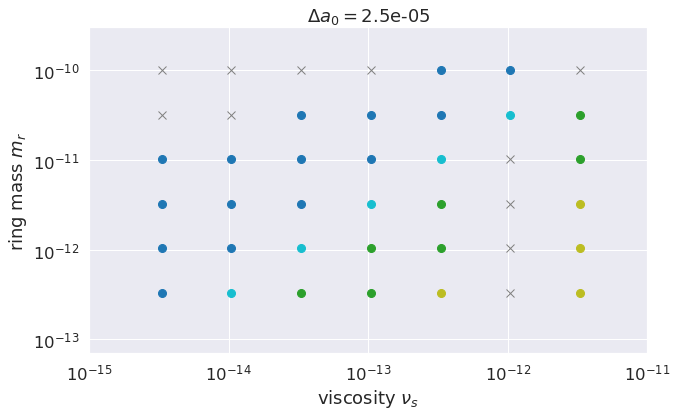

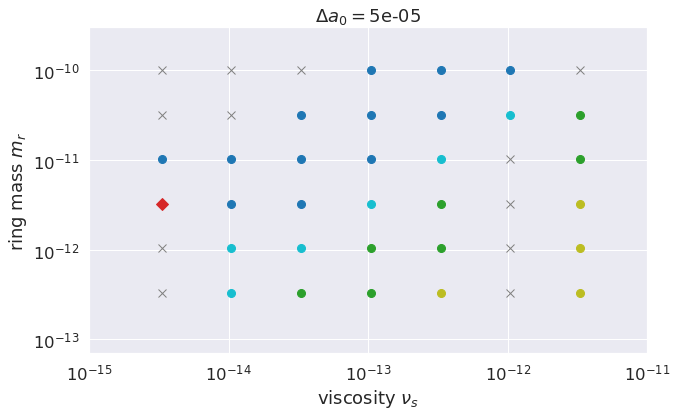

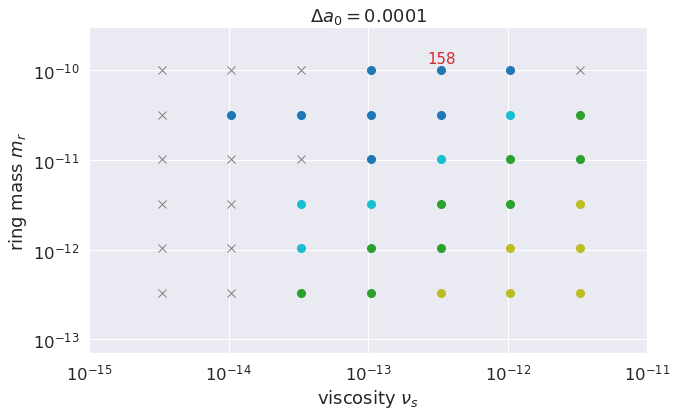

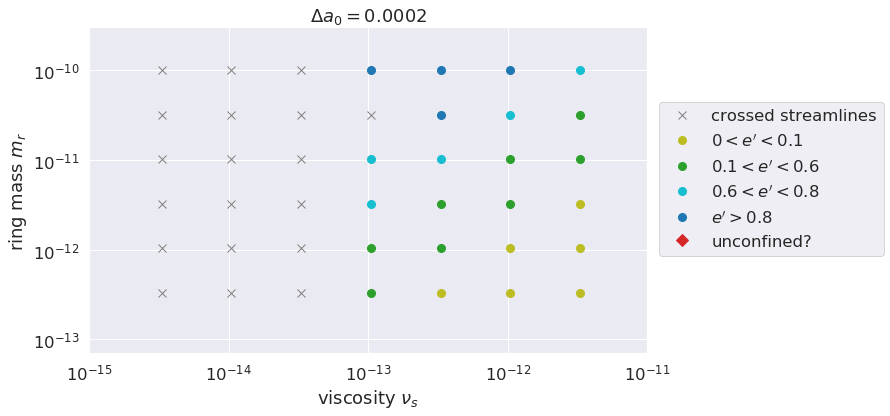

In [15]:
#show grid of simulation outcomes
df = df_results
radial_widths = np.sort(df.radial_width.unique())
e_prime_brackets = [(0.0, r"$0 < e'<0.1$", color_seq[8]),
                    (0.1, r"$0.1<e'<0.6$", color_seq[2]),
                    (0.6, r"$0.6<e'<0.8$", color_seq[9]),
                    (0.8, r"$e'>0.8$", color_seq[0])]
for radial_width in radial_widths:
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    #x for sims that crossed streamlines
    idx = (dfs.outcome == 'crossed streamlines')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='crossed streamlines')
    #dot for self-confining sims
    idx = (dfs.outcome == 'self-confining')
    dfss = dfs[idx]
    for e_prime_bracket, label, color in e_prime_brackets:
        idx = (dfss.e_prime_bracket == e_prime_bracket)
        dfsss = dfss[idx]
        xp = dfsss.shear_viscosity
        yp = dfsss.total_ring_mass
        p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=8, label=label, color=color)
    #diamond for simulation complete sims
    idx = (dfs.outcome == 'unconfined')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    color = color_seq[3]
    p = ax.plot(xp, yp, linestyle='none', marker='D', markersize=8, color=color, label='unconfined?')
    #annotate the nominal sim_id
    idx = (dfs.nominal == True)
    if (idx.sum() > 0):
        dfss = dfs[idx]
        sim_id = str(dfss.sim_id.values[0])
        xp = dfss.shear_viscosity.values[0]
        yp = dfss.total_ring_mass.values[0]
        xy = (0.8*xp, 1.2*yp)
        color = color_seq[3]
        p = ax.annotate(sim_id, xy, fontsize=15, color=color)
    p = ax.set_xscale('log')
    p = ax.set_yscale('log')
    p = ax.set_xlabel(r'viscosity $\nu_s$')
    p = ax.set_ylabel(r'ring mass $m_r$')
    title = r'$\Delta a_0 = $' + str(radial_width)
    p = ax.set_title(title)
    p = ax.set_ylim(7.0e-14, 3.0e-10)
    p = ax.set_xlim(1.0e-15, 1.0e-11)
    if (radial_width == radial_widths[-1]):
        p = ax.legend(loc=(1.02, 0.3))
    file = 'figs/sim_grid_da_'+ str(radial_width) + '.pdf'
    print 'file = ', file
    plt.savefig(file, bbox_inches='tight')

In [16]:
#conda install scikit-learn
#conda install pyarrow

number of e_prime_bracket=0.8 sims =  39
number of sims plotted =  5


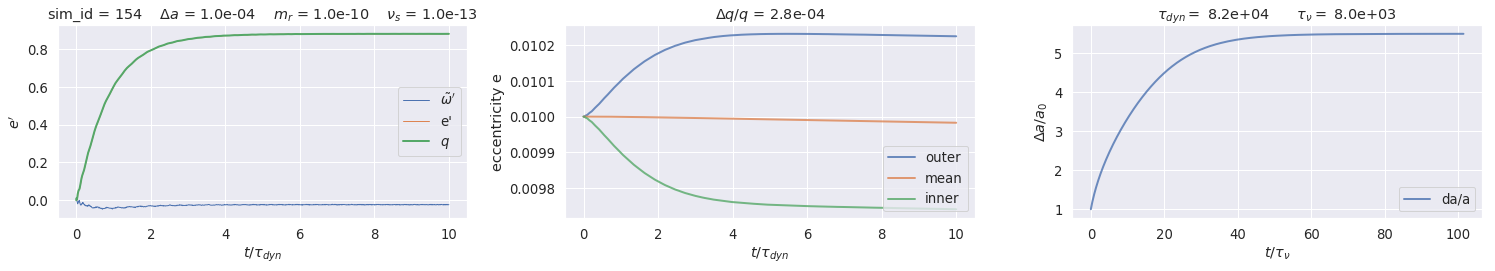

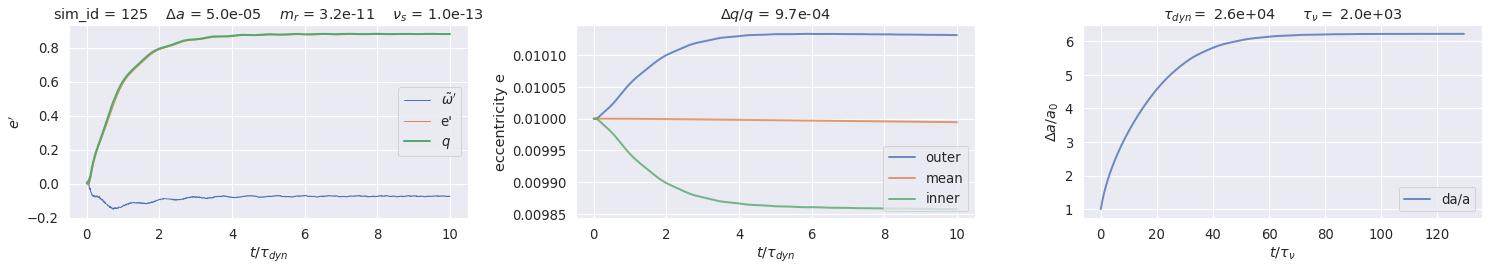

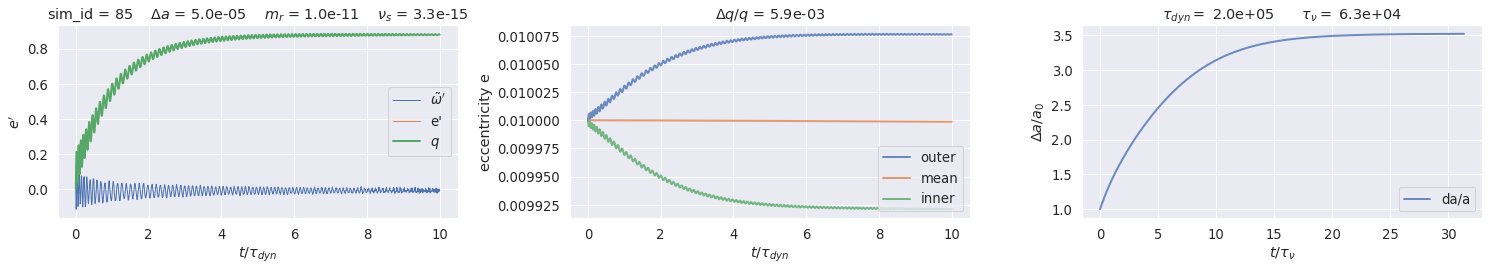

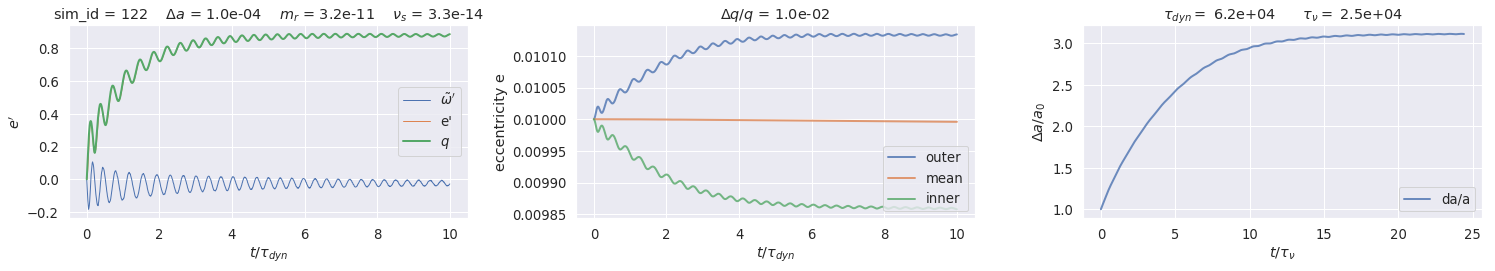

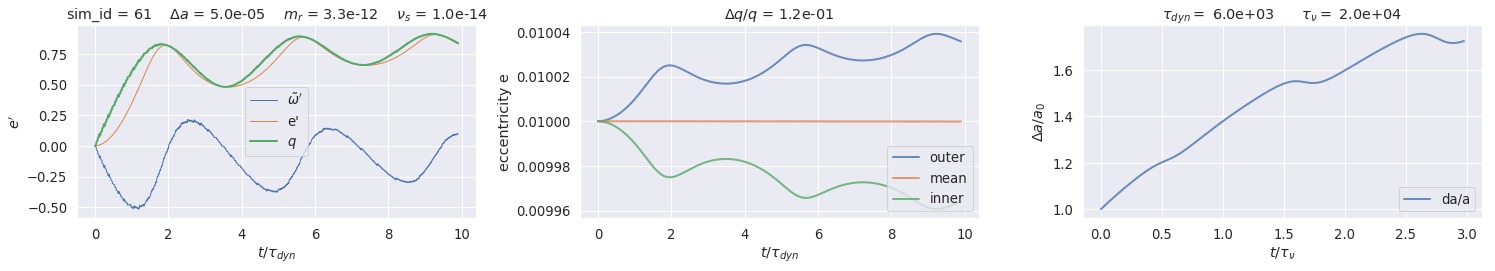

In [17]:
#generate summary plots for sample of e_prime_bracket=0.8 sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.8
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.8 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.6 sims =  21
number of sims plotted =  5


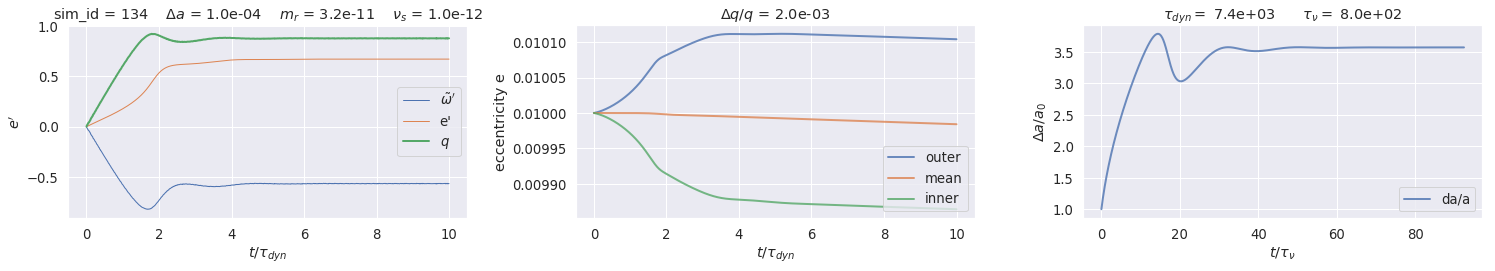

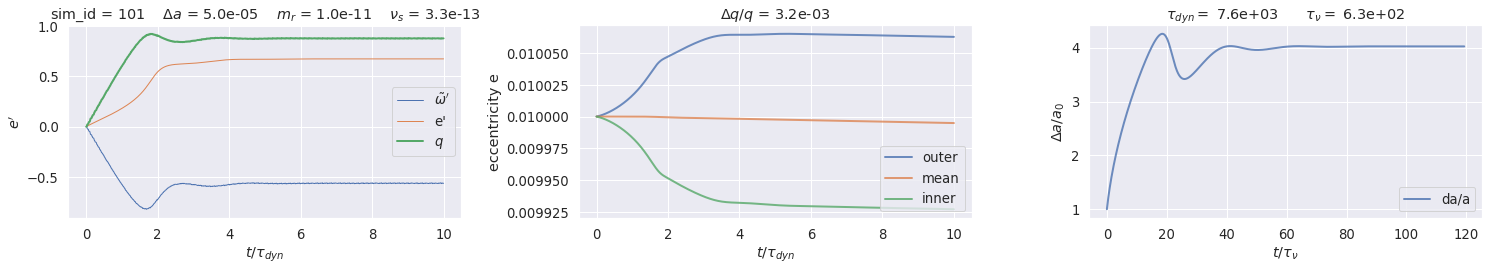

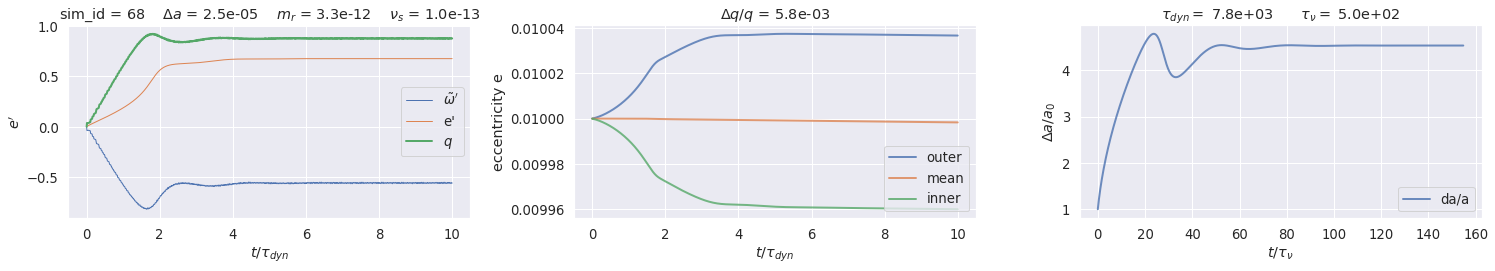

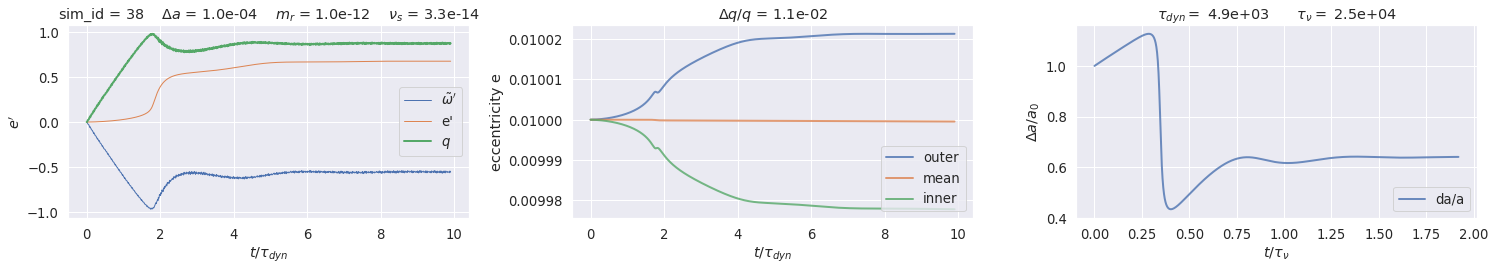

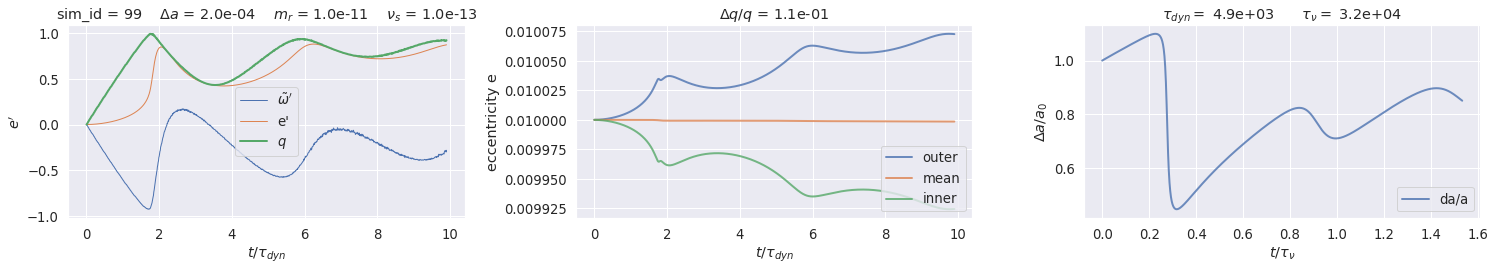

In [18]:
#generate summary plots for sample of e_prime_bracket=0.6 (ie 0.6<e'<0.8) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.6
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.6 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.1 sims =  31
number of sims plotted =  5


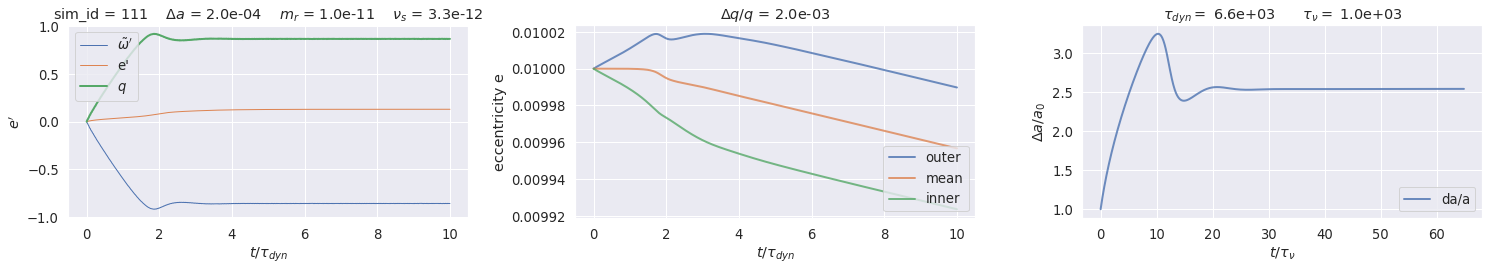

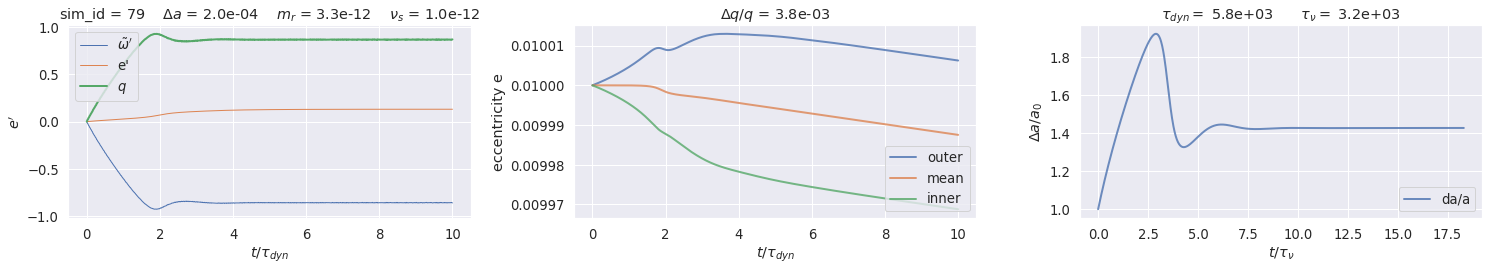

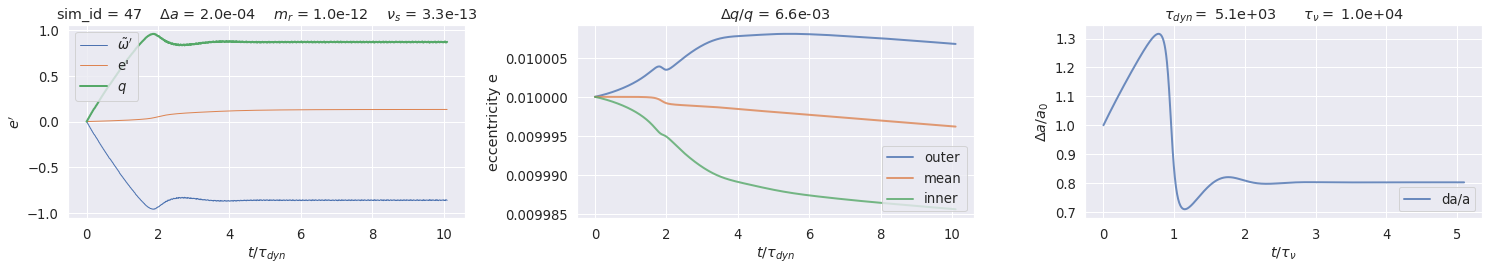

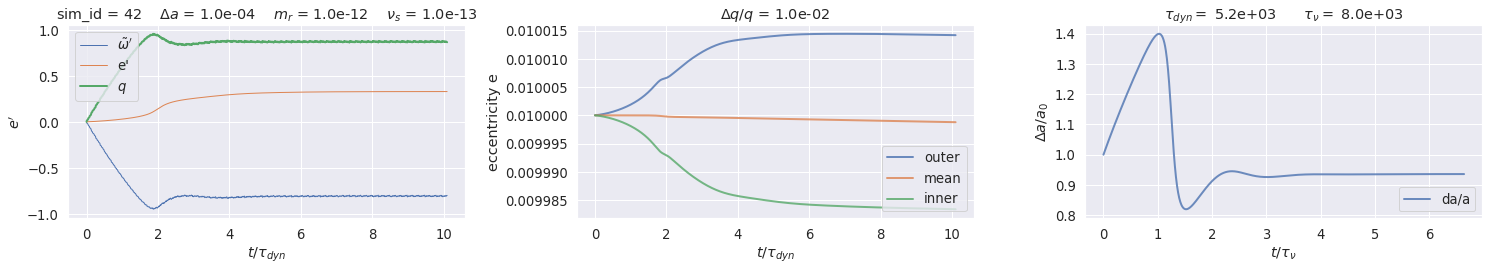

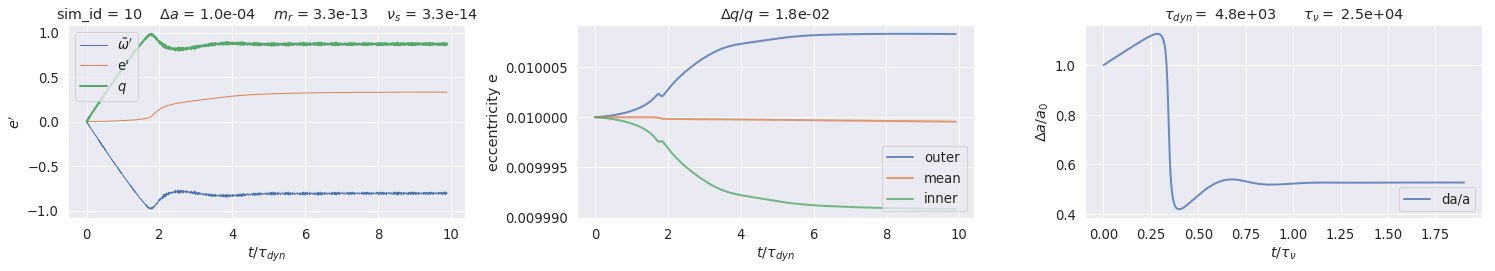

In [19]:
#generate summary plots for sample of e_prime_bracket=0.1 (ie 0.1<e'<0.6) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.1
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.1 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.0 sims =  20
number of sims plotted =  5


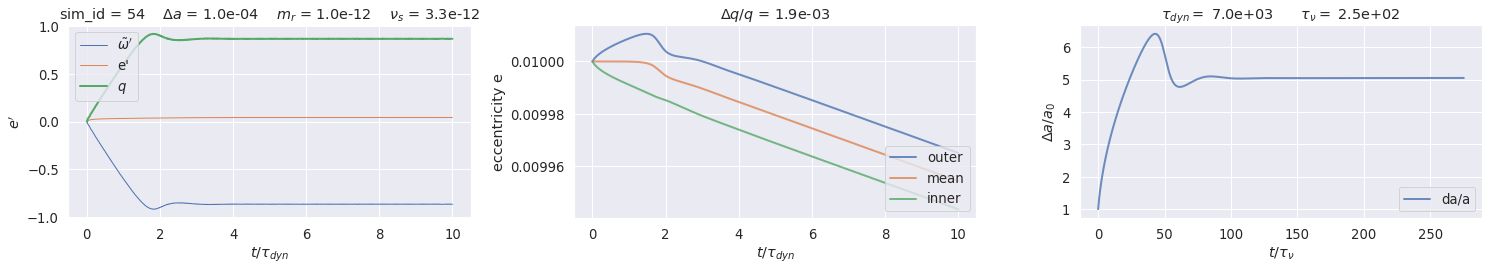

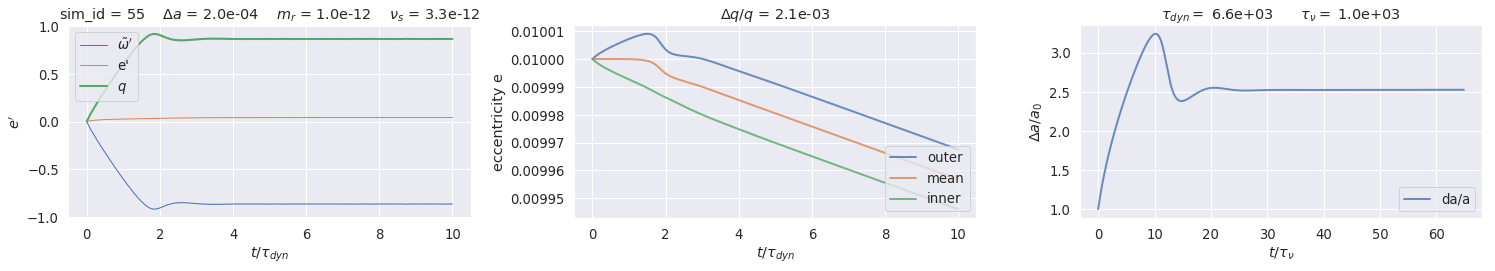

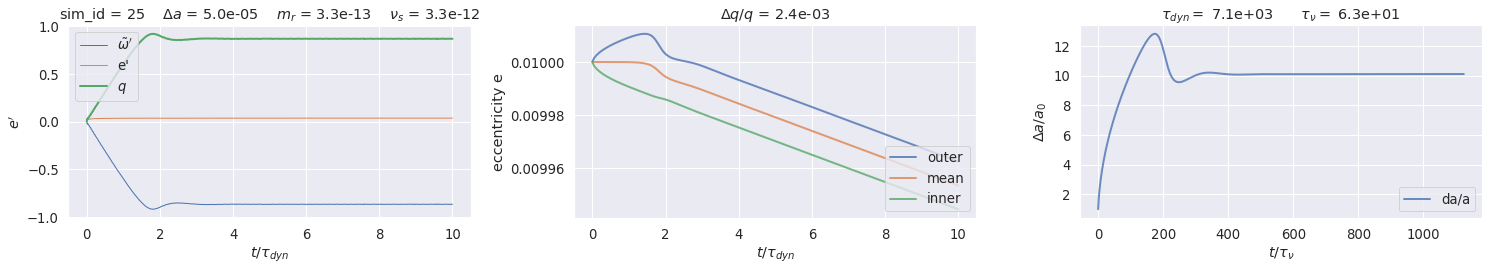

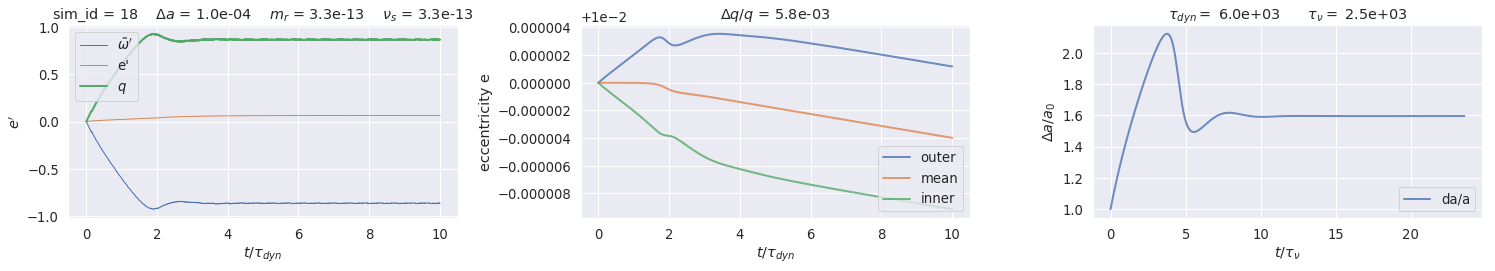

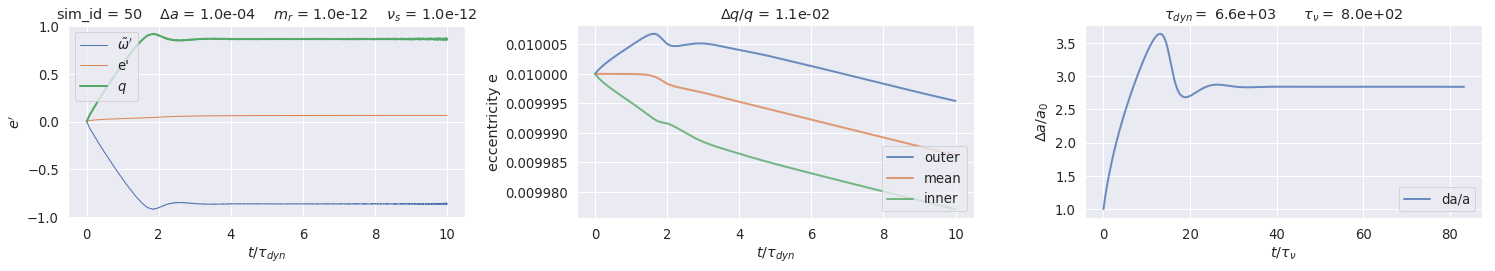

In [20]:
#generate summary plots for sample of e_prime_bracket=0.0 (ie 0.0<e'<0.1) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.0
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.0 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of unconfined sims =  1


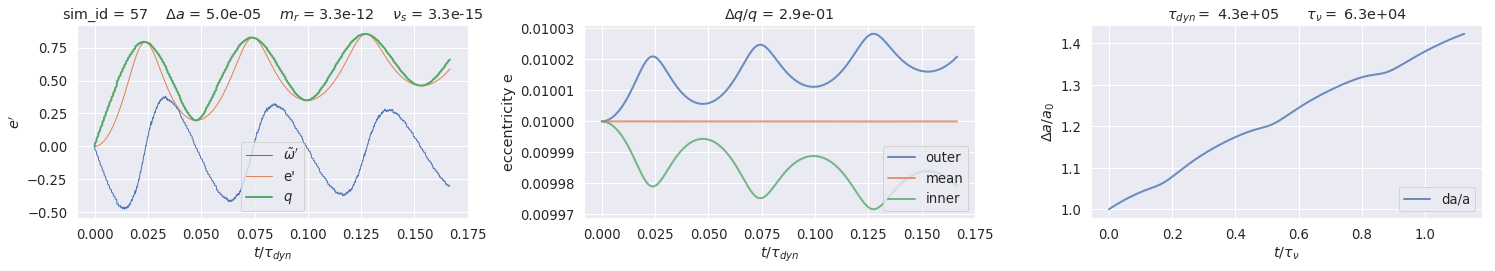

In [21]:
#generate summary plots for all unconfined sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
idx = (df.outcome == 'unconfined')
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of unconfined sims = ', len(dfs)
for idx, row in dfs.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

In [22]:
#done
time_exec_min = (tm.time() - t_start)/60
print 'time_exec_min = ', time_exec_min

time_exec_min =  0.696517686049
